In [1]:
import pandas as pd, numpy as np
from fidap import fidap_client
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, linear_model

In [2]:
# replace with your API key
import config
fidap = fidap_client(db='sf_gcp', api_key=config.FIDAP_API_KEY)

# Can we use ML to predict the Future Change Over 1m for a stock using it's price and insider trades?

## Data Retrieval from Fidap
Get data from the daily ticker data and the insider trades data

In [3]:
trading_data = fidap.sql(f"""select "insider_trades"."ticker", "insider_trades"."filingdate", "insider_trades"."transactionshares",
    "insider_trades"."transactionvalue", "daily"."open", "daily"."close", "daily"."volume", "daily"."pc_1d", "daily"."pc_1w", "daily"."pc_1m", "daily"."fc_1d", "daily"."fc_1w", "daily"."fc_1m","daily"."marketcap"
    from "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."insider_trades" AS "insider_trades", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."tickers" AS "tickers", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."daily" AS "daily"
    where 
    "insider_trades"."ticker" = "tickers"."ticker" and 
    "insider_trades"."ticker" = "daily"."ticker" and
    "insider_trades"."filingdate" = "daily"."date" and
    "insider_trades"."transactionvalue" > 100000 and 
    "insider_trades"."securitytitle" = 'Common Stock' ORDER BY "insider_trades"."filingdate" DESC;""")

Remove the data with Null "fc_1m" columns

In [4]:
trading_data.shape

(295012, 14)

In [5]:
trading_data.dropna(inplace=True)
trading_data = trading_data[trading_data.fc_1m < 2]
size = trading_data.shape[0]

## Split the Data into Train and Test

In [6]:
train_df, test_df = trading_data.iloc[:round((size/3)*2)], trading_data.iloc[round((size/3)*2):]

## Look at Data; Discover Patterns, Create Features and Find Correlations

In [7]:
train_df.dtypes

ticker                object
filingdate            object
transactionshares      int64
transactionvalue       int64
open                 float64
close                float64
volume               float64
pc_1d                float64
pc_1w                float64
pc_1m                float64
fc_1d                float64
fc_1w                float64
fc_1m                float64
marketcap            float64
dtype: object

In [8]:
train_df.describe()

,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap
count,1.827290e+05,1.827290e+05,182729.000000,182729.000000,1.827290e+05,182729.000000,182729.000000,182729.000000,182729.000000,182729.000000,182729.000000,1.827290e+05
mean,-1.554595e+04,2.788704e+06,100.748772,100.736984,2.868525e+06,0.000881,0.014868,0.059651,0.000559,0.001706,0.007581,2.766328e+10
std,2.302806e+06,5.117802e+07,120.351229,120.222298,8.565581e+06,0.040754,0.119933,0.246038,0.036302,0.073884,0.153378,7.527358e+10
min,-1.440000e+08,1.000010e+05,0.020000,0.020000,0.000000e+00,-0.820556,-0.963727,-0.970515,-0.652326,-0.777778,-0.830523,4.000000e+05
25%,-1.091300e+04,1.801750e+05,31.928000,31.960000,3.346300e+05,-0.011476,-0.020250,-0.026745,-0.012267,-0.027081,-0.056102,1.946600e+09
50%,-3.417000e+03,3.538400e+05,64.440000,64.450000,8.432570e+05,0.000634,0.010293,0.041285,0.000038,0.002235,0.009612,5.987200e+09
75%,1.641000e+03,8.690400e+05,125.570000,125.320000,2.224973e+06,0.013058,0.042721,0.116835,0.012617,0.030508,0.072155,2.168280e+10
max,7.025000e+08,8.917183e+09,3475.000000,3582.500000,4.010487e+08,4.800000,15.909621,23.786325,3.310861,1.695652,1.882812,2.248598e+12


Create 2 new features, one checks whether it was a buy or sell and the other is a transaction value to marketcap ratio.

In [9]:
def create_features(data: pd.DataFrame):
    """
    Create Features namely mc_pct: Transaction Value as a Percent of the Marketcap and sale: Boolean of whether it was a buy or sale on that day.
    """
    data_ = data.copy(deep=True)
    data_['mc_pct'] = data_['transactionvalue'] / data_['marketcap']
    data_['sell'] = np.where(data_['transactionshares'] > 0, 0, 1)
    return data_

In [10]:
train_df = create_features(train_df)
test_df = create_features(test_df)

In [11]:
train_df.head()

,ticker,filingdate,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap,mc_pct,sell
9676,CRVL,2021-02-25,-1000,103503,103.54,101.50,37971.0,-0.019703,-0.023569,-0.006946,0.000000,0.012611,0.031034,1.814500e+09,0.000057,1
9677,SILK,2021-02-25,-7296,391321,53.00,54.59,389733.0,0.027286,-0.021158,-0.080357,0.003297,-0.048727,-0.151676,1.853800e+09,0.000211,1
9678,SILK,2021-02-25,-2306,123682,53.00,54.59,389733.0,0.027286,-0.021158,-0.080357,0.003297,-0.048727,-0.151676,1.853800e+09,0.000067,1
9679,BLKB,2021-02-25,-4100,289817,72.12,69.80,242067.0,-0.029342,-0.044098,0.061436,-0.014040,-0.024499,0.004871,3.377000e+09,0.000086,1
9680,FOE,2021-02-25,-11313,175046,15.70,15.35,349376.0,-0.024778,0.016556,0.019934,0.033876,0.106840,0.092508,1.263200e+09,0.000139,1


Check the correlation of the numeric features and the label to see if there exists any correlations between the values.

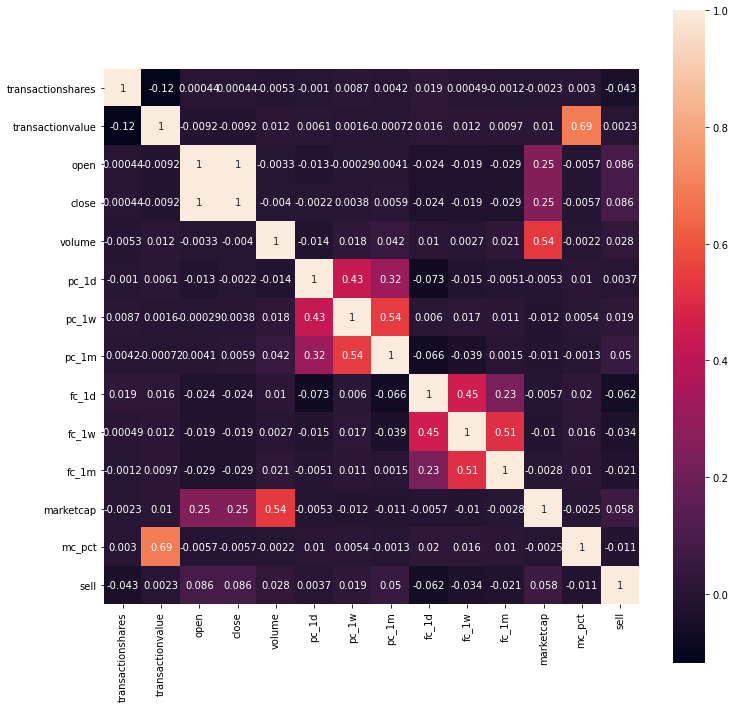

In [12]:
insider_trading_corr = train_df.corr()
f, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(insider_trading_corr,square=True, annot=True)

We need to check the distribution of the label we want to predict fc_1m and see if it is normall distributed.

<AxesSubplot:xlabel='fc_1m', ylabel='Count'>

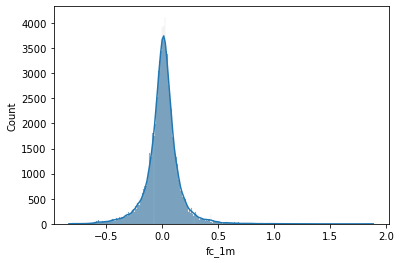

In [13]:
sns.histplot(train_df['fc_1m'], kde=True)

Get the labels and features to be used to make the prediction.

In [14]:
features = train_df.columns.tolist()[2:]
labels = [features.pop(features.index("fc_1m"))]

In [15]:
insider_trading_train_features = train_df[features].copy(deep=True)
insider_trading_train_labels = np.array(train_df[labels])
insider_trading_test_features = test_df[features].copy(deep=True)

In [16]:
train_features = np.array(insider_trading_train_features)
test_features = np.array(insider_trading_test_features)

In [17]:
import numpy.random as nr
import sklearn.model_selection as ms
nr.seed(9988)
indx = range(train_features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.3)
X_train = train_features[indx[0],:]
y_train = np.ravel(insider_trading_train_labels[indx[0]])
X_test = train_features[indx[1],:]
y_test = np.ravel(insider_trading_train_labels[indx[1]])

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train[:,:-1])
X_train[:,:-1] = scaler.transform(X_train[:,:-1])
X_test[:,:-1] = scaler.transform(X_test[:,:-1])
test_features[:,:-1] = scaler.transform(test_features[:,:-1])

In [19]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [20]:
import sklearn.metrics as sklm
import scipy.stats as ss
import math
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 28)

Mean Square Error      = 0.017352817921833873
Root Mean Square Error = 0.1317300949739044
Mean Absolute Error    = 0.08629234667246721
Median Absolute Error  = 0.0560428943319574
R^2                    = 0.2670837833989951
Adjusted R^2           = 0.2667226157282421


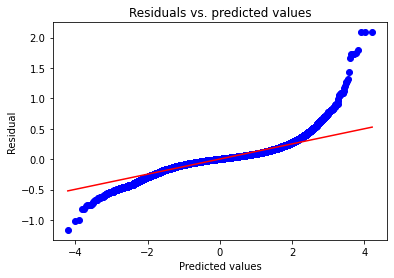

In [21]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)

In [22]:
import xgboost as xg
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 20, seed = 123) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
y_score = xgb_r.predict(X_test)

In [23]:
print_metrics(y_test, y_score, 28)

Mean Square Error      = 0.01468074948195056
Root Mean Square Error = 0.1211641427236233
Mean Absolute Error    = 0.08146164784022486
Median Absolute Error  = 0.05476541268440552
R^2                    = 0.37994166620972303
Adjusted R^2           = 0.3796361128339435
